# **How to Leverage the AutoGen Framework for Collaborative Task Management**

The AutoGen framework enables the management of dynamic, collaborative group chats using specialized agents, including code generators, critics, and comparers. It provides conversational agents powered by LLMs, tools, or human input, allowing for effective task completion through automated chat. This setup supports both tool-based and human involvement within multi-agent conversations.

## **Framework Setup**
In this project, I configured:

- **CRITIC Agent**: Reviews the Python code implemented by the Assistant Agent (code_generator) and the code executor.
- **Comparer Agent**: Analyzes and provides insights on final results.


To manage agent interactions, I used the GroupChatManager class.

This Manager agent coordinates the agents, selects the next speaker, requests responses, and broadcasts them to other agents, creating a seamless, collaborative environment.

## **Use Case: Optimizing a Momentum Trading Strategy**
**Objective**: Use the AutoGen framework to optimize a momentum trading strategy and select the best short/long periods for moving averages.

### **Agent Instructions:**

- Implement a momentum trading strategy.
- Propose various pairs of moving averages.
- Calculate buy and sell signals for each pair.
- Compute and evaluate returns for each moving average pair.

## **Agent Roles**
- **Assistant Agent**: Generates Python code to implement the trading strategy, fetch historical prices, create plots, and perform calculations.
- **UserProxyAgent**: Executes the code.
- **Critic Agent**: Reviews and scores the code based on defined metrics.
- **Comparer Agent**: Compares results for different moving average pairs.
- **Group Chat Manager:** Oversees agent interactions and manages the workflow to complete the task.

🛑 **This content is intended for educational purposes only and is not an investment recommendation.** 🛑

[Hanane DUPOUY](https://www.linkedin.com/in/hanane-d-algo-trader)

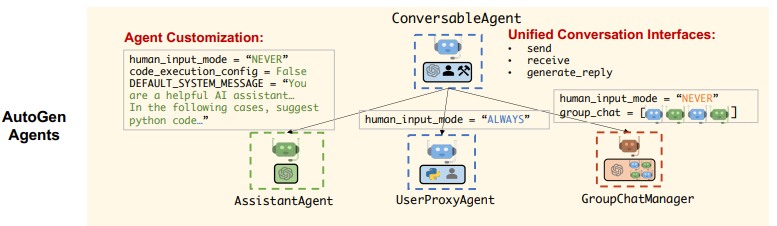

In [46]:
#Conversable Agent
import PIL.Image
# #local image
image_path='./code/AutoGen_Conversable_agent.png'
img = PIL.Image.open(image_path)
img
# source: https://arxiv.org/pdf/2308.08155
# ==> AutoGen: Enabling Next-Gen LLM
# Applications via Multi-Agent Conversation

# Install and Import Lib

In [ ]:
!pip install pyautogen -q

In [9]:
import os
from autogen import AssistantAgent, UserProxyAgent, ConversableAgent, GroupChat, GroupChatManager
from autogen.coding import LocalCommandLineCodeExecutor

# Agents

## AssistantAgent & UserProxyAgent

We will create AssistantAgent and UserProxyAgent:

*   What is the difference between both agents?:



**AssistantAgent**:
* It is behaving like an AI Assistant by using an LLM under the hood.

* It is not requiring human input or code execution.

* It is the standard form of an AI assistant: You give it an instruction like summarize a given text or write a Python code, or refine and correct a given Python code.

* The behavior is instructed by the system message.


**UserProxyAgent**:
It's more sophisticated agent. It can:
* Interact with human input
* Execute Code
* Call functions or tools
* You can either enable or disable the use of an LLM. If disabled the Agent will execute code. If enabled and no code to execute, it will generate answers using the LLM.


✔ ✅ These 2 agents are sublcasses of a more generic class called **ConversableAgent**, which is the highest-level agent abstraction.


This generic class allows agents to converse with each other through the exchange of the messages while retaining the possibility of human intervention (if asked) to finish the required task. You can create an agent, with only these 2 agents. However, to render the chat more dynamic and allow for other agents to interven such as the CRITIC agent, I'll also use GroupChatManager.

## GroupChatManager

GroupChatManager Agent allows a dynamic group chat

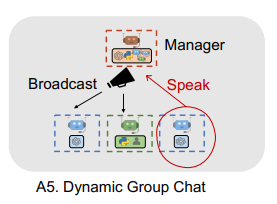

In [45]:
import PIL.Image
# #local image
image_path='./code/autogen_dynamic_group_chat.png'
img = PIL.Image.open(image_path)
img
# source: https://arxiv.org/pdf/2308.08155
# ==> AutoGen: Enabling Next-Gen LLM
# Applications via Multi-Agent Conversation

**GroupChatManager**

The **Manager agent**, which is an instance of the GroupChatManager class, serves as the conductor of conversation among agents and repeats the following three steps:

1. Dynamically Selecting a single speaker (Code_generator for example),
2. Asking the speaker to respond, and collecting responses from this selected speaker, and
3. Broadcasting the selected speaker’s message to all other agents


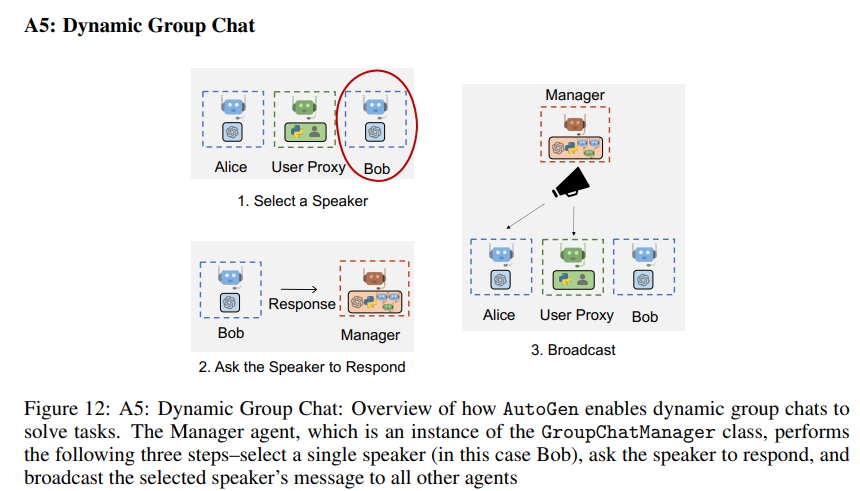

In [44]:
import PIL.Image
# #local image
image_path='./code/AutoGen_GroupChatManager.png'
img = PIL.Image.open(image_path)
img
# source: https://arxiv.org/pdf/2308.08155
# ==> AutoGen: Enabling Next-Gen LLM
# Applications via Multi-Agent Conversation

## Initiate the Command Line Code executor

You'll see a folder created with "code" name.

* I'm using Google Colab. I'm seeing it in the top left menu ==> folders ==> "Code"

In [15]:
code_executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="code",
)

## LLM Config

In [4]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

In [6]:
config_list = [{"model": "gpt-4o", "api_key": OPENAI_API_KEY}]

# First Run : code_generator + code_executor + critic + groupchat

## **Goal**:

I instruct the multi-agent system to provide momentum trading strategy (one sugesstion of pair short, long window moving average), compute buy/sell signals and the final return. Plot all this information and also save it in various files (python file, csv file, and png images).

## **Multi-agent collaboration**

I created five agents to optimize this process:
- Assistant Agent: Proposes Python code to implement the momentum trading strategy, fetch historical prices, generate plots, and perform various computations.
- UserProxyAgent: Executes the code.
- Critic: Reviews the Python code implementation and scores it based on four metrics (see code for details).
- Group Chat Manager: Manages interactions between the agents to complete the final task.

In [7]:
# config_list = [{"model": "gpt-4o", "api_key": OPENAI_API_KEY}]
code_executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="code",
)

# Create an AssistantAgent: Code Generator
code_generator = AssistantAgent(
    name="Code_generator",
    llm_config={
        "config_list": config_list
    },
    human_input_mode="NEVER"
)
# human_input_mode per default: assistant.human_input_mode ==> 'NEVER'

# Create a UserProxyAgent with code execution and no LLM config.
code_executor = UserProxyAgent(
    name="Code_executor",
    code_execution_config={
        "executor": code_executor
    },
    llm_config=False,
    human_input_mode="NEVER"
)

# Create an AssistantAgent: Critic Assistant
critic = AssistantAgent(
    name="Critic_agent",
    system_message = """Critic. You are an expert assistant in algorithmic trading stratgies.
    You are highly qualified in evaluating the quality of the code to implement trading strategies, calculation buy and sell signal and computing the final return of the strategy.
    You carrefully evaluate the code based on these aspects:
    - Code Execubality: Is the code executable? Are all libraries available to be executed easily?
    - Calculation: Is the proposed code implement acurately the requested trading strategy? Does every aspect and parts of the trading startegy well implemented?
    - Buy and Sell Signals: Are these signals computed correctly?
    - Return: Is the final return computed correctly?

    You must provide a score for each of these aspects: Code Execubality, Calculation, Buy and Sell Signals, Return.
    """,
    llm_config={
        "config_list": config_list
    }
)

groupchat = GroupChat(agents=[code_executor, code_generator, critic], messages=[], max_round=5)
manager = GroupChatManager(groupchat=groupchat, llm_config={"config_list": config_list})

## Start Chating

In [8]:
chat_result = code_executor.initiate_chat(
    manager,
    message="""Let's proceed step by step:
    1- Propose a Python code implementation of one momentum trading strategy
    2- Save in a file called 'momentum_trading_strategy.py'
    2- Apply this code to NVIDIA historical price of the current year.
    4- Save the results in a csv file called 'nvidia_trading_strategy.csv'
    5- Plot this trading strategy and save it in a file called 'nvidia_trading_strategy.png'
    6- Calculate buy and sell signals. Plot them and save it in a file called 'buy_sell_signals.png'
    7- Compute the final return of the strategy. Plot it and save it in a file called 'final_return.png'
    """,
)

Code_executor (to chat_manager):

Let's proceed step by step:
    1- Propose a Python code implementation of one momentum trading strategy
    2- Save in a file called 'momentum_trading_strategy.py'
    2- Apply this code to NVIDIA historical price of the current year.
    4- Save the results in a csv file called 'nvidia_trading_strategy.csv'
    5- Plot this trading strategy and save it in a file called 'nvidia_trading_strategy.png'
    6- Calculate buy and sell signals. Plot them and save it in a file called 'buy_sell_signals.png'
    7- Compute the final return of the strategy. Plot it and save it in a file called 'final_return.png'
    

--------------------------------------------------------------------------------

Next speaker: Code_generator

Code_generator (to chat_manager):

Let's implement and execute each step clearly. We will start by writing the Python code for a simple momentum trading strategy, save it to a file, and work through testing it with NVIDIA's historical pri

## **Takeaways:**

**Agents Workflow**

Even between the code generator and the code executor, there’s a reflective process: when the code from the generator isn’t executable, the generator adjusts its initial implementation based on the executor’s feedback.


```
--------------------------
**Next speaker: Code_executor**


 EXECUTING CODE BLOCK (inferred language is python)...
Code_executor (to chat_manager):

exitcode: 1 (execution failed)


--------------------------
**Next speaker: Code_generator**

Code_generator (to chat_manager):

It seems that the `pandas_datareader` library is having trouble accessing Yahoo

```




Once the execution succeeds ==> The critic agent takes over.
```
Next speaker: Critic_agent

Critic_agent (to chat_manager):

The script executed successfully and generated the required CSV and PNG files. However, we encountered a `FutureWarning`
```

"Functional Feedback":


As I didn't specify the date of today, the agent fetch historical prices based on its cutoff knowledge and give me 2023 prices.



## Plots

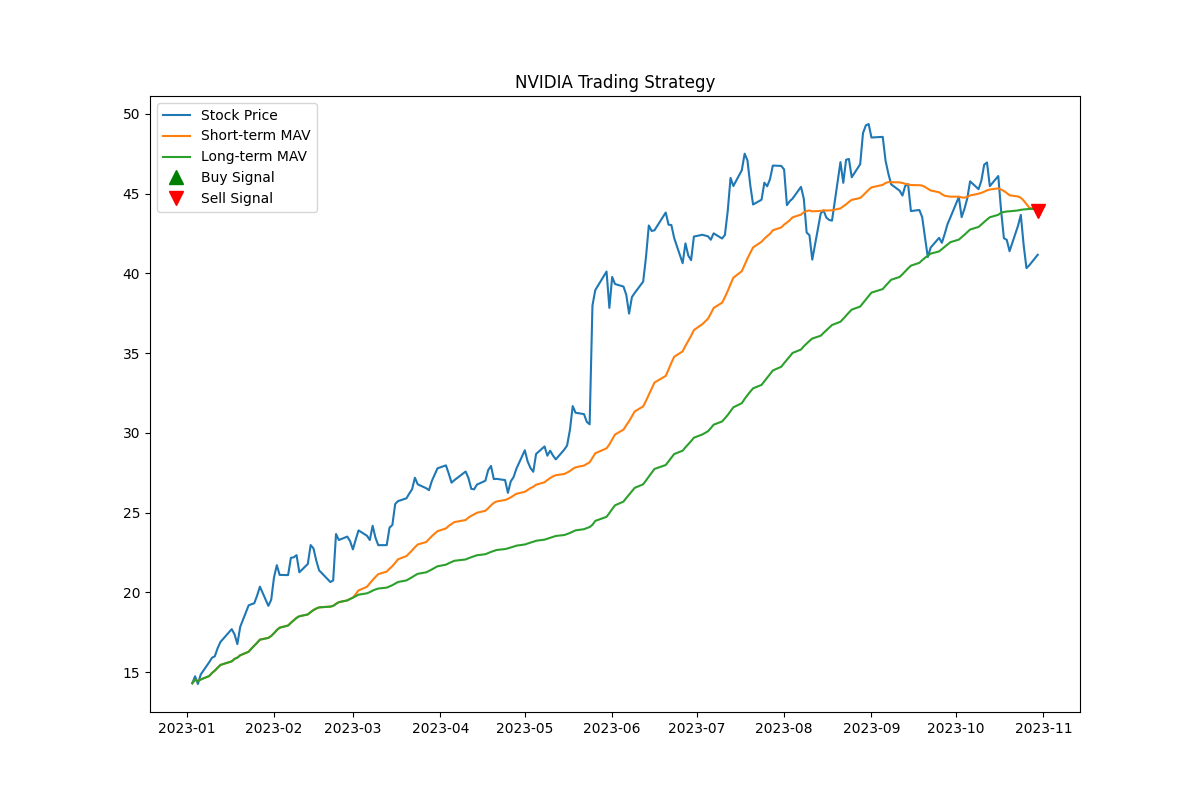

In [9]:
import PIL.Image
# #local image
image_path='./code/nvidia_trading_strategy.png'
img = PIL.Image.open(image_path)
img

# **Second Run: Adding other agents and Asking date first**

## **Goal**

- In this second run, I’m using the multi-agent framework to apply the same process with different pairs of short/long windows for the moving average.

- The goal is to generate multiple implementations of the momentum trading strategy and calculate the returns for each short/long window pair.

- With the comparer agent, we’ll receive a detailed analysis of each pair, including insights on buy/sell signals and performance.

- To avoid retrieving prices from 2023, I began by asking the multi-agent framework, ‘What is today’s date?’. This question triggers the first agent (code_generator) to generate Python code, which the code_executor then runs to determine today’s date. With the current date identified, the system can then fetch historical prices accordingly.

## **Multi-agent collaboration**

In [16]:
# config_list = [{"model": "gpt-4o", "api_key": OPENAI_API_KEY}]
code_executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="code",
)

# Create an AssistantAgent: Code Generator
code_generator = AssistantAgent(
    name="Code_generator",
    llm_config={
        "config_list": config_list
    },
    human_input_mode="NEVER"
)
# human_input_mode per default: assistant.human_input_mode ==> 'NEVER'

# Create a UserProxyAgent with code execution and no LLM config.
code_executor = UserProxyAgent(
    name="Code_executor",
    code_execution_config={
        "executor": code_executor
    },
    llm_config=False,
    human_input_mode="NEVER"
)

# Create an AssistantAgent: Critic Assistant
critic = AssistantAgent(
    name="Critic_agent",
    system_message = """Critic. You are an expert assistant in algorithmic trading stratgies.
    You are highly qualified in evaluating the quality of the code to implement trading strategies, calculation buy and sell signal and computing the final return of the strategy.
    You carrefully evaluate the code based on these aspects:
    - Code Execubality: Is the code executable? Are all libraries available to be executed easily?
    - Calculation: Is the proposed code implement acurately the requested trading strategy? Does every aspect and parts of the trading startegy well implemented?
    - Buy and Sell Signals: Are these signals computed correctly?
    - Return: Is the final return computed correctly?

    You must provide a score for each of these aspects: Code Execubality, Calculation, Buy and Sell Signals, Return.
    """,
    llm_config={
        "config_list": config_list
    },
    human_input_mode="NEVER"
)

# Create an AssistantAgent: Critic Assistant
comparer = AssistantAgent(
    name="Comparer",
    system_message = """For each pair of moving averages, comment the results of buy and sell signals and the final computed return.
    """,
    llm_config={
        "config_list": config_list
    },
    human_input_mode="NEVER"
)


groupchat = GroupChat(agents=[code_executor, code_generator, critic, comparer], messages=[], max_round=20)
manager = GroupChatManager(groupchat=groupchat, llm_config={"config_list": config_list})

In [17]:
chat_result = code_executor.initiate_chat(
    manager,
    message="""Let's proceed step by step:
    1- Which date is today?
    2- Propose a Python code implementation of a momentum trading strategy with 2 moving averages: short and long.
    3- Save in a file called 'momentum_trading_strategy.py'
    4- Apply this code to NVIDIA historical price of the current year, with 4 different pair of moving averages.
    5- For each pair of moving averages, save the results in a csv file called 'nvidia_trading_strategy_{pair_of_moving_average}.csv'
    6- For each pair of moving averages, plot this trading strategy and save it in a file called 'nvidia_trading_strategy_{pair_of_moving_average}.png'
    7- For each pair of moving averages, calculate buy and sell signals. Plot them and save it in a file called 'buy_sell_signals_{pair_of_moving_average}.png'
    8- For each pair of moving averages, compute the final return of the strategy, and provide these results in a markdown format.
    """,
)

Code_executor (to chat_manager):

Let's proceed step by step:
    1- Which date is today?
    2- Propose a Python code implementation of a momentum trading strategy with 2 moving averages: short and long.
    3- Save in a file called 'momentum_trading_strategy.py'
    4- Apply this code to NVIDIA historical price of the current year, with 4 different pair of moving averages.
    5- For each pair of moving averages, save the results in a csv file called 'nvidia_trading_strategy_{pair_of_moving_average}.csv'
    6- For each pair of moving averages, plot this trading strategy and save it in a file called 'nvidia_trading_strategy_{pair_of_moving_average}.png'
    7- For each pair of moving averages, calculate buy and sell signals. Plot them and save it in a file called 'buy_sell_signals_{pair_of_moving_average}.png'
    8- For each pair of moving averages, compute the final return of the strategy, and provide these results in a markdown format.
    

---------------------------------------

The multi-agent framework tries various pair of short/long window for moving average, and computed their returns:

### Moving Average Pairs and Returns:

1. **5, 20 Moving Averages:**
   - **Final Return:** 84.48%
   
2. **10, 50 Moving Averages:**
   - **Final Return:** 5.04%
   
3. **20, 100 Moving Averages:**
   - **Final Return:** 40.62%

4. **50, 200 Moving Averages:**
   - **Final Return:** 8.78%


One can have a look on the comparer results to get some insights. For example:

### Moving Average Pair: (5, 20)
- **Buy Signals:** Generated when the short-term moving average (5-day) crosses above the long-term moving average (20-day). The frequent crossovers in a shorter span make this setup more responsive to market changes.
- **Sell Signals:** Occurred when the short-term moving average crosses below the long-term moving average, indicating a potential downtrend.
- **Performance:** This pair yielded a striking final return of 84.48%, indicating high responsiveness and profitability under volatile market conditions.


One needs to consider other indicators to assess for the final return.

🛑 **This content is intended for educational purposes only and is not an investment recommendation.** 🛑

## **Plots**

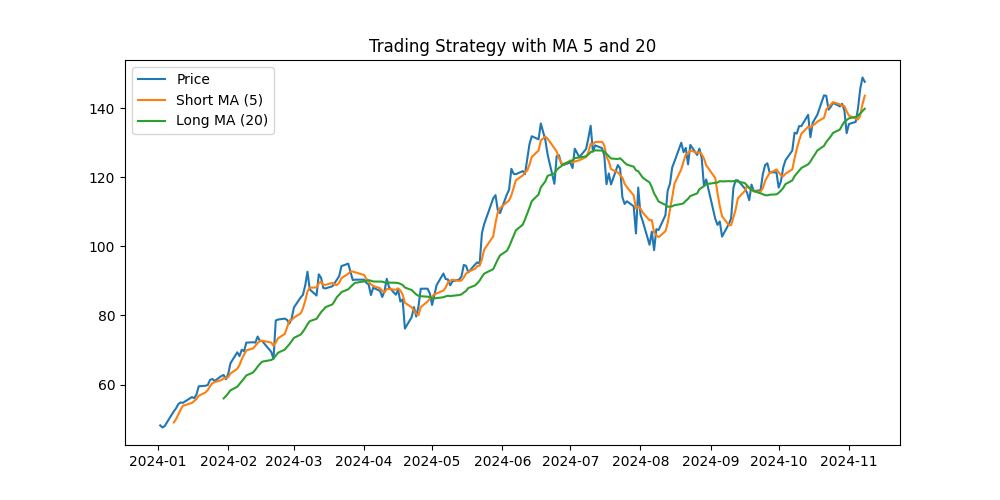

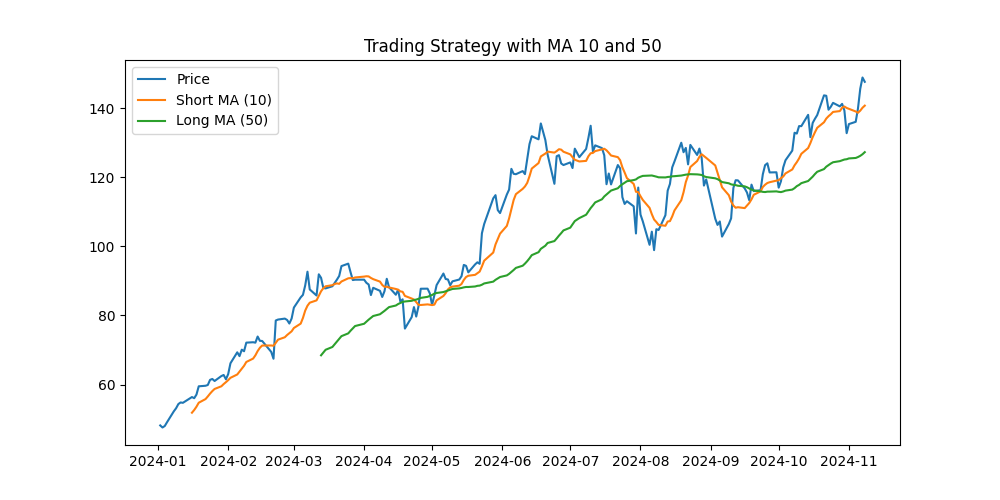

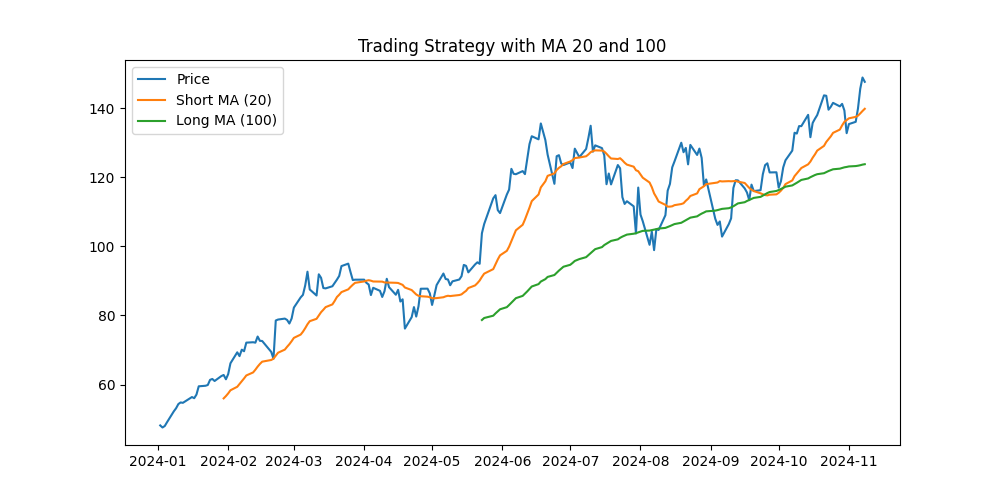

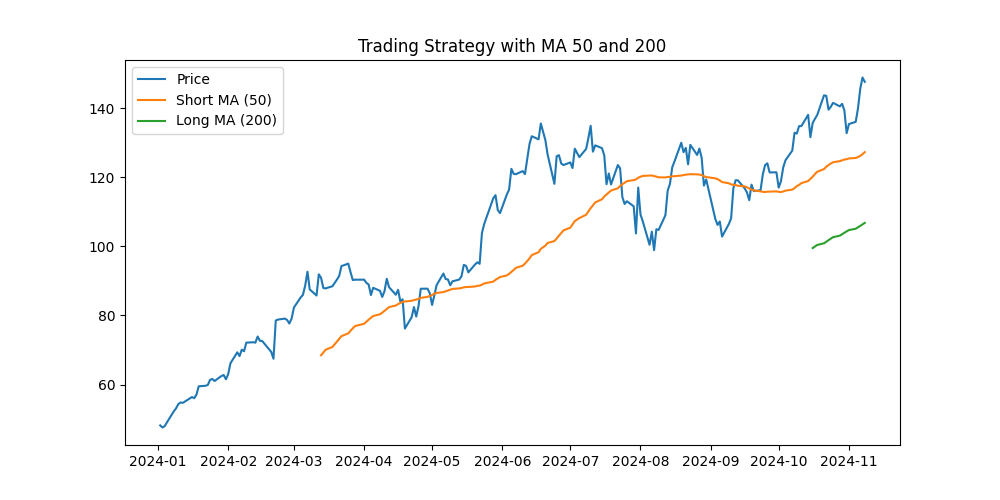

In [18]:
import PIL.Image
# #local image
ma_pairs = [(5, 20), (10, 50), (20, 100), (50, 200)]
for pair in ma_pairs:
    image_path=f'./code/nvidia_trading_strategy_{pair[0]}_{pair[1]}.png'
    img = PIL.Image.open(image_path)
    display(img)

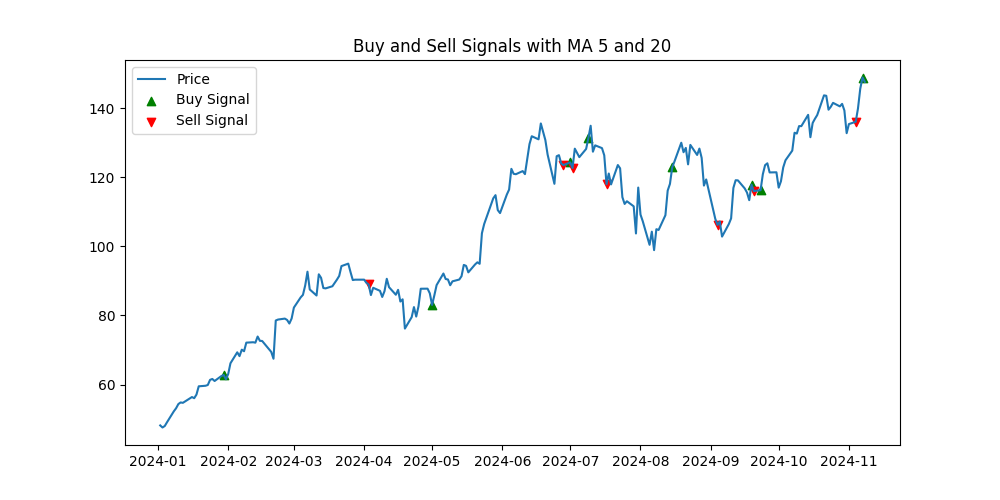

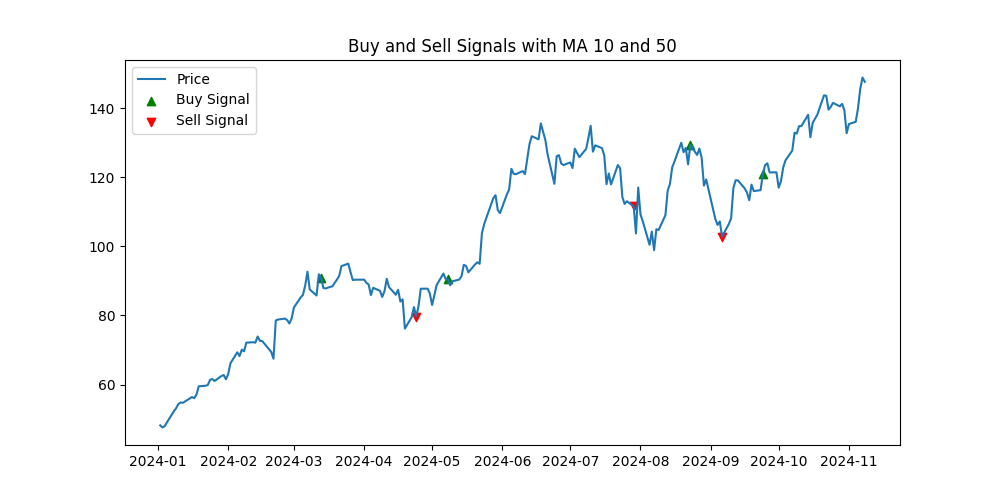

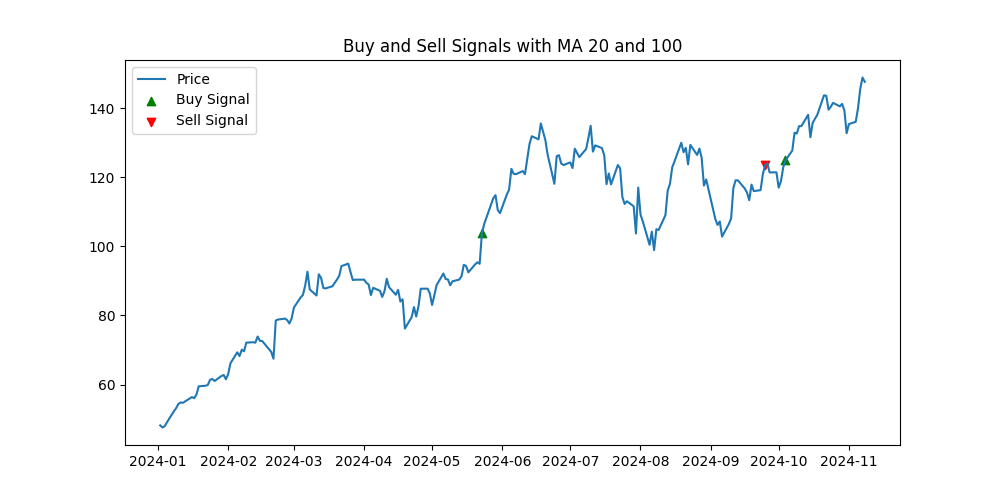

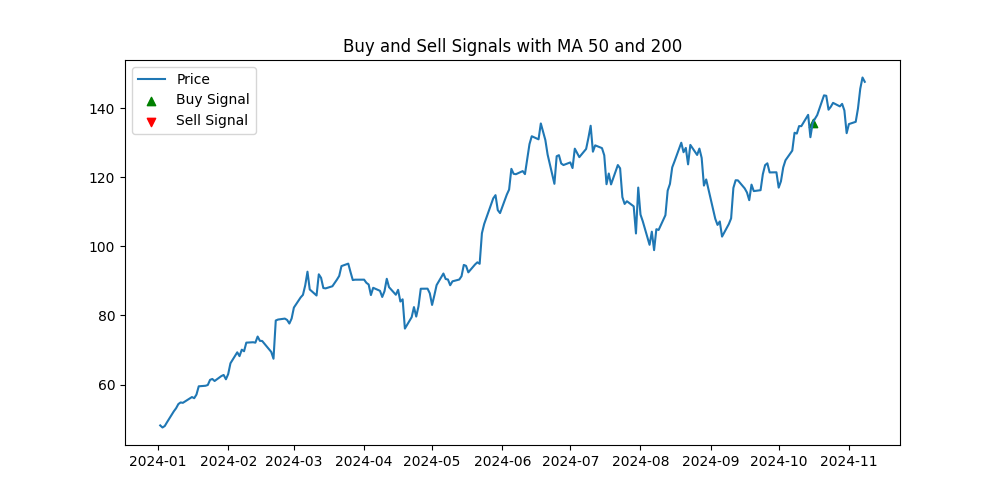

In [19]:
import PIL.Image
# #local image
ma_pairs = [(5, 20), (10, 50), (20, 100), (50, 200)]
for pair in ma_pairs:
    image_path=f'./code/buy_sell_signals_{pair[0]}_{pair[1]}.png'
    img = PIL.Image.open(image_path)
    display(img)

In [21]:
import pandas as pd

In [38]:
df_5_20 = pd.read_csv('./code/nvidia_trading_strategy_5_20.csv')
df_10_50 = pd.read_csv('./code/nvidia_trading_strategy_10_50.csv')
df_20_100 = pd.read_csv('./code/nvidia_trading_strategy_20_100.csv')
df_50_200 = pd.read_csv('./code/nvidia_trading_strategy_50_200.csv')
df_5_20.tail()

,Date,price,short_mavg,long_mavg,signal,positions
212,2024-11-04 00:00:00+00:00,136.050003,136.959998,137.480000,0.0,-1.0
213,2024-11-05 00:00:00+00:00,139.910004,136.691998,137.831000,0.0,0.0
214,2024-11-06 00:00:00+00:00,145.610001,137.945999,138.479000,0.0,0.0
215,2024-11-07 00:00:00+00:00,148.880005,141.170001,139.182500,1.0,1.0
216,2024-11-08 00:00:00+00:00,147.630005,143.616003,139.824001,1.0,0.0


In [42]:
df_5_20.tail(10)

,Date,price,short_mavg,long_mavg,signal,positions
207,2024-10-28 00:00:00+00:00,140.520004,141.123999,133.807000,1.0,0.0
208,2024-10-29 00:00:00+00:00,141.250000,140.656000,135.019500,1.0,0.0
209,2024-10-30 00:00:00+00:00,139.339996,140.612000,136.044000,1.0,0.0
210,2024-10-31 00:00:00+00:00,132.759995,139.081998,136.539500,1.0,0.0
211,2024-11-01 00:00:00+00:00,135.399994,137.853998,137.063499,1.0,0.0
212,2024-11-04 00:00:00+00:00,136.050003,136.959998,137.480000,0.0,-1.0
213,2024-11-05 00:00:00+00:00,139.910004,136.691998,137.831000,0.0,0.0
214,2024-11-06 00:00:00+00:00,145.610001,137.945999,138.479000,0.0,0.0
215,2024-11-07 00:00:00+00:00,148.880005,141.170001,139.182500,1.0,1.0
216,2024-11-08 00:00:00+00:00,147.630005,143.616003,139.824001,1.0,0.0


In [40]:

df_50_200.tail()

,Date,price,short_mavg,long_mavg,signal,positions
212,2024-11-04 00:00:00+00:00,136.050003,125.5874,105.102430,1.0,0.0
213,2024-11-05 00:00:00+00:00,139.910004,125.8564,105.503710,1.0,0.0
214,2024-11-06 00:00:00+00:00,145.610001,126.2026,105.932395,1.0,0.0
215,2024-11-07 00:00:00+00:00,148.880005,126.6680,106.369985,1.0,0.0
216,2024-11-08 00:00:00+00:00,147.630005,127.2688,106.800050,1.0,0.0


In [ ]:
df_50_200.tail(50)

In [47]:
# # Compute final return
# returns = df_10_50['price'].pct_change().fillna(0)
# strategy_returns = returns * df_10_50['signal'].shift(1).fillna(0)
# cumulative_return = (1 + strategy_returns).cumprod()#[-1] - 1
# cumulative_return.values[-1]-1

# **Final Takeways:**

- Easy to implement.
- The Critic Agent functions effectively, reflecting on and improving the code with useful recommendations.
- The workflow is smooth and transparent, with clear visibility of each agent's role at every stage.